#### Sequential Feature Selection of PCs for Random Forest model using PV/GPH/EHF as input.

File duplicated on May 8, 2025.

File editted on June 4th. Updated to use new timeseries of data for temperature. Also attempting to remove necessity for multiple solvers by timeseries. 

This specific file is for the "real" analysis and will not have different PCs depending on leadtimes. 

I would like to identify the # of nodes that represent >80% of the variance for each feature. Then, I will do two models.  

In [1]:
# relevant import statements
import math
import pickle
import random

##just to stop the excess number of warnings
import warnings
warnings.filterwarnings("ignore")
from random import randint, sample, seed

# plotting related imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  # statistical data visualization
import xarray as xr

from eofs.standard import Eof

The bulk of this file to start is copied from the previous EOF file/my EOF test file. 

##### First, I am going to pickle in the input data. I will then remove the seasonal climo from the dataset...

I had to actually download the data locally and upload it here to the H100 cluster in the ./Dissertation_Coding/data folder because I could not call it from my home directory. 

In [2]:
# load input data
infile = open("../eof_data/vertanom_u.p","rb",)
u_input = pickle.load(infile)  ##vertical U cross section
infile.close()

infile = open("../eof_data/vertanom_ehf.p","rb",)
ehf_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../eof_data/vertanom_gph.p","rb",)
gph_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

In [3]:
u_input.shape  ##62 years, october through march,

(62, 182, 37, 36)

In [4]:
gph_input.shape

(62, 182, 37, 180)

In [5]:
ehf_input.shape

(62, 182, 37, 180)

### This is where I cahnged to one solver for all leadtimes.  

Rather than 119 for 30, 129 for 20, and 133 for 14 it is now based on that full offest winter relative to temperature. 

In [6]:
print('14 DAYS')
##flatten array to just the dates relevant to my models. 
flat_u_14 = u_input[:62, 19:168, :, :].reshape((62 * 149, 37, 36))
print(flat_u_14.shape)

flat_EHF_14 = ehf_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
print(flat_EHF_14.shape)

flat_GPH_14= gph_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
print(flat_GPH_14.shape)

14 DAYS
(9238, 37, 36)
(9238, 37, 180)
(9238, 37, 180)


#### Great, so I have everything uploaded and reduced to daily anomalies with the seasonal climo removed. Fantastic, lol. 

##### Attempt at EOF analysis/PC decomp based on Zheng's example code. 

In [7]:
Usolver_14 = Eof(flat_u_14)
EHFsolver_14 = Eof(flat_EHF_14)
GPHsolver_14 = Eof(flat_GPH_14)

In [8]:
print("Pickle Out Solvers ...")
pickle.dump(Usolver_14, open("./solvers/Usolver_full.p", 'wb'))
pickle.dump(EHFsolver_14, open("./solvers/EHFsolver_full.p", 'wb'))
pickle.dump(GPHsolver_14, open("./solvers/GPHsolver_full.p", 'wb'))

Pickle Out Solvers ...


### I will now go through and see if there is a difference in the number of PCs based on leadtime. 

U-wind:

14 days = 11

###########

EHF:

14 days = 50

###########

GPH:

14 days = 11

In [14]:
variance = []
for i in range(1, 50):
    nmode = i
    EOF = Usolver_14.eofs(neofs=nmode, eofscaling=0)
    EOF2d = EOF.reshape(EOF.shape[0], EOF.shape[-2] * EOF.shape[-1])
    # print(np.shape(EOF2d))
    pv = np.dot(EOF2d, np.transpose(EOF2d))
    EOF_nw2d = EOF2d
    # print(pv.shape)
    eigenv = Usolver_14.eigenvalues(neigs=nmode)
    VarEx = Usolver_14.varianceFraction(neigs=nmode) * 100
    variance.append(sum(VarEx))
variance[:11]

[38.853670860653,
 56.562913047203935,
 63.96985863351581,
 70.01702169218112,
 75.0529441428651,
 78.85075990205742,
 82.02274551406435,
 84.71923095572102,
 86.80497573850676,
 88.44517069548067,
 89.83322610573777]

In [15]:
variance = []
for i in range(1, 50):
    nmode = i
    EOF = GPHsolver_14.eofs(neofs=nmode, eofscaling=0)
    EOF2d = EOF.reshape(EOF.shape[0], EOF.shape[-2] * EOF.shape[-1])
    # print(np.shape(EOF2d))
    pv = np.dot(EOF2d, np.transpose(EOF2d))
    EOF_nw2d = EOF2d
    # print(pv.shape)
    eigenv = GPHsolver_14.eigenvalues(neigs=nmode)
    VarEx = GPHsolver_14.varianceFraction(neigs=nmode) * 100
    variance.append(sum(VarEx))
variance[:11]

[32.52162074014369,
 51.58448785014194,
 66.28678021504311,
 72.371686187259,
 77.56307783486467,
 81.8990243160475,
 84.24734057940074,
 86.01796486432785,
 87.53942005627944,
 88.7721489685465,
 89.9312049600785]

In [13]:
variance = []
for i in range(1, 50):
    nmode = i
    EOF = EHFsolver_14.eofs(neofs=nmode, eofscaling=0)
    EOF2d = EOF.reshape(EOF.shape[0], EOF.shape[-2] * EOF.shape[-1])
    # print(np.shape(EOF2d))
    pv = np.dot(EOF2d, np.transpose(EOF2d))
    EOF_nw2d = EOF2d
    # print(pv.shape)
    eigenv = EHFsolver_14.eigenvalues(neigs=nmode)
    VarEx = EHFsolver_14.varianceFraction(neigs=nmode) * 100
    variance.append(sum(VarEx))
variance[:50]

[20.23911114284975,
 32.41876102494376,
 40.8408790565007,
 48.328513015614156,
 52.70834914383556,
 56.699588476067504,
 59.70656649409623,
 62.44928621057148,
 64.61412830296119,
 66.57705525222188,
 68.32639415669827,
 69.94923614428313,
 71.35713021264225,
 72.73172649059626,
 73.88695797832406,
 75.01301092781283,
 76.02627534404715,
 76.99217546494191,
 77.90306266733648,
 78.77114981073213,
 79.50528525359846,
 80.1747964065806,
 80.81178018392488,
 81.44333485330137,
 82.03844955464905,
 82.61517688355279,
 83.12620049609002,
 83.62344684073987,
 84.09993958418355,
 84.56529200516138,
 84.99790317942593,
 85.40471965477936,
 85.79269251660914,
 86.17153913156295,
 86.54244239471721,
 86.89806950998172,
 87.24204622817288,
 87.5799792004034,
 87.88789488622947,
 88.19089969387095,
 88.4679404353294,
 88.73539046142842,
 88.99964096303742,
 89.25608799710962,
 89.50957729682037,
 89.73666403136684,
 89.96263540283937,
 90.182706296965,
 90.39819504030507]

### Check the first few PCs to make sure I can ignore them for vortex spin-up. 

In [18]:
from EOF_def import EOF_def

In [26]:
## U
U_EOF_nw, U_EOF_nw2d, U_eigenv, U_VarEx, U_PC = EOF_def(Usolver_14, 11)
## EHF
EHF_EOF_nw, EHF_EOF_nw2d, EHF_eigenv, EHF_VarEx, EHF_PC = EOF_def(EHFsolver_14, 50)
## GPH
GPH_EOF_nw, GPH_EOF_nw2d, GPH_eigenv, GPH_VarEx, GPH_PC = EOF_def(GPHsolver_14, 11)

<class 'numpy.ndarray'> (9238, 11)
<class 'numpy.ndarray'> (9238, 50)
<class 'numpy.ndarray'> (9238, 11)


In [37]:
test = U_PC.reshape(62,149,11)
test2 = test[:,:143,:]
test2.reshape((62*143),11).shape ##20 days

(8866, 11)

In [38]:
test = U_PC.reshape(62,149,11)
test2 = test[:,:133,:]
test2.reshape((62*133),11).shape ##30 days

(8246, 11)

In [27]:
area = ["TEST", "test"]

U_plot = ["PC 1", "PC 2", "PC 3", "PC 4"]
##1,4,3,0
U_index = [0,1,2,3]

EHF_plot = ["PC 1", "PC 2"]
##21,14
EHF_index = [1,2]

GPH_plot = ["PC 1", "PC 2", "PC 3", "PC 4"]
## 56, 54, 53, 55
GPH_index = [0,1,2,3]

In [28]:
##set lat and lon arrays
##separate set of longitudes for PV and others
lat = np.arange(90, 18, -2)
lon = np.arange(0, 360, 2)

lev = np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70., 100., 125., 150., 175., 200., 225., 250., 300., 350., 400., 
                450., 500., 550., 600., 650., 700., 750., 775., 800., 825., 850., 875., 900., 925., 950., 975., 1000.])
print(lev[::-1])

[1000.  975.  950.  925.  900.  875.  850.  825.  800.  775.  750.  700.
  650.  600.  550.  500.  450.  400.  350.  300.  250.  225.  200.  175.
  150.  125.  100.   70.   50.   30.   20.   10.    7.    5.    3.    2.
    1.]


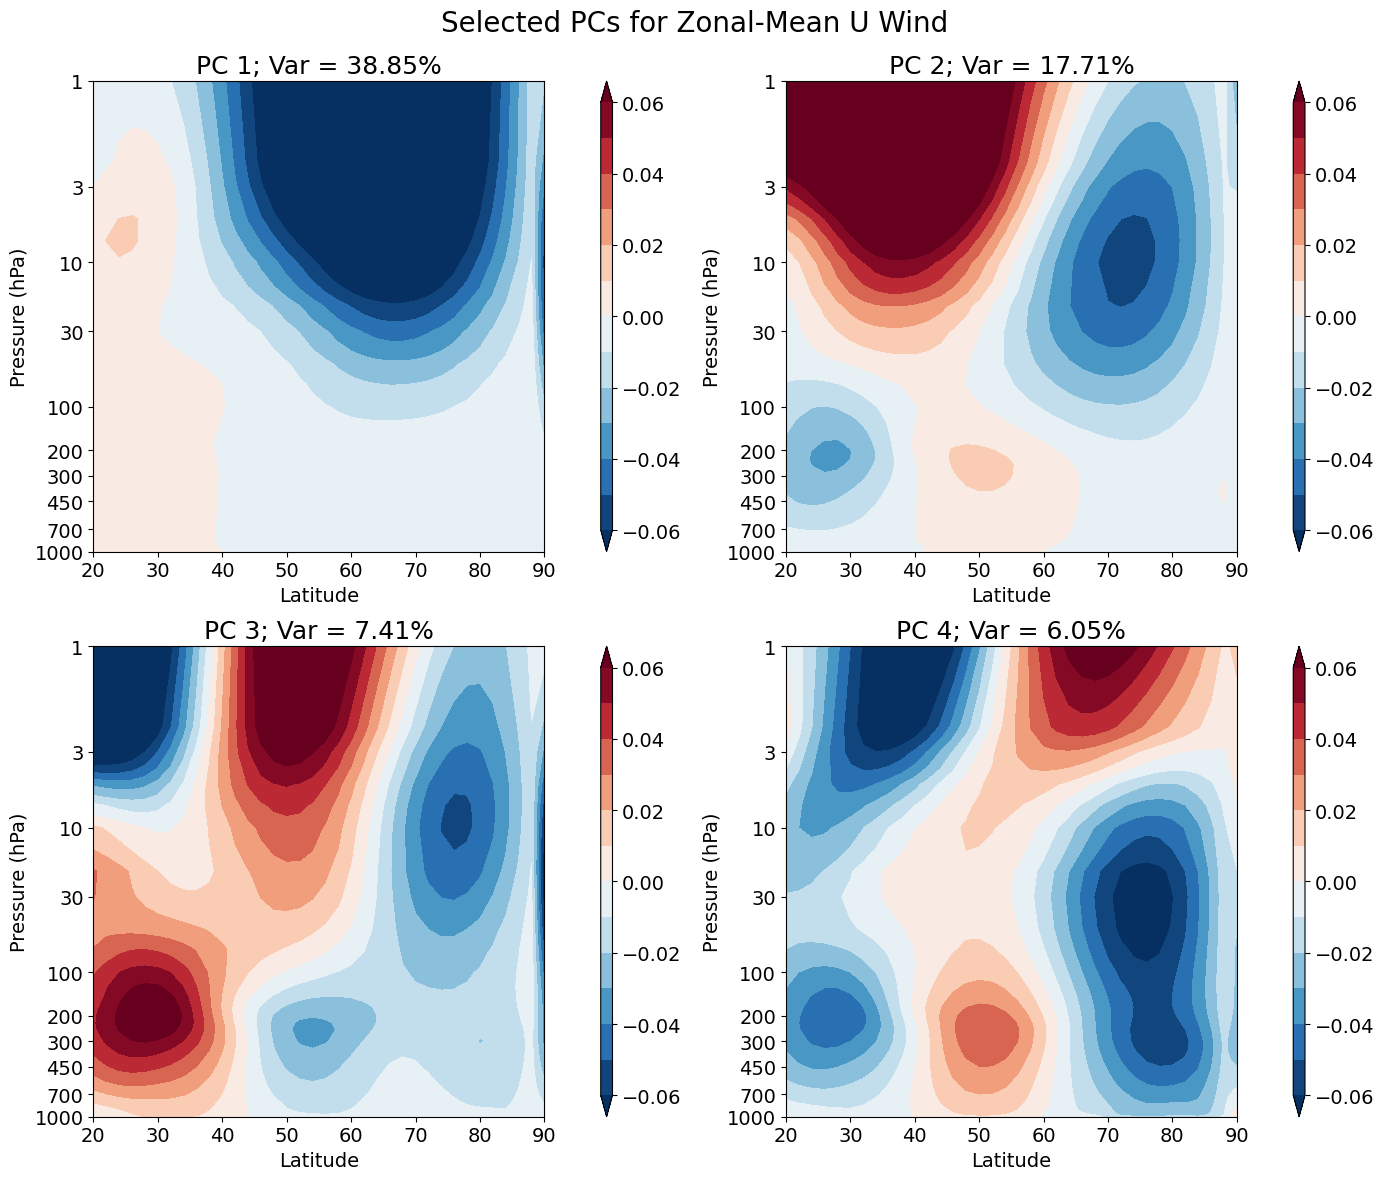

In [29]:
fs = 16

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.suptitle("Selected PCs for Zonal-Mean U Wind",fontsize=20)   

axes = axes.flatten()
#remove the last (empty) axis

for i in range(0, 4):
    color = "RdBu_r"
    # colorbar options:
    colorbarMin = -0.06
    colorbarMax = 0.06
    colorspace = 0.01

    PC_ind = U_index[i]

    clevel = np.arange(colorbarMin, colorbarMax + colorspace, colorspace)
    axes[i].set_title(
        f"{U_plot[i]}; Var = {round(U_VarEx[PC_ind], 2)}%", fontsize=18
    )

    h = axes[i].contourf(
        lat,
        lev,
        U_EOF_nw[PC_ind, :, :],
        clevel,
        cmap=color,
        extend="both",
    )
    cbar = plt.colorbar(
        h, orientation="vertical", shrink=1, fraction=0.1, pad=0.1, aspect=40
    )
    cbar.ax.tick_params(labelsize=fs-2)
    # colorLabel='Z (m)'
    # cbar.set_label(label=colorLabel,fontsize=10)

    axes[i].tick_params(labelsize=fs-2)
    axes[i].invert_yaxis()
    axes[i].set_yscale('symlog')
    axes[i].set_ylabel('Pressure (hPa)', fontsize=fs-2)
    axes[i].set_yticks([1, 3, 10, 30, 100, 200, 300, 450, 700, 1000]) 
    axes[i].get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

    axes[i].set_xlim(20, 90)
    axes[i].set_xlabel('Latitude', fontsize=fs-2)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

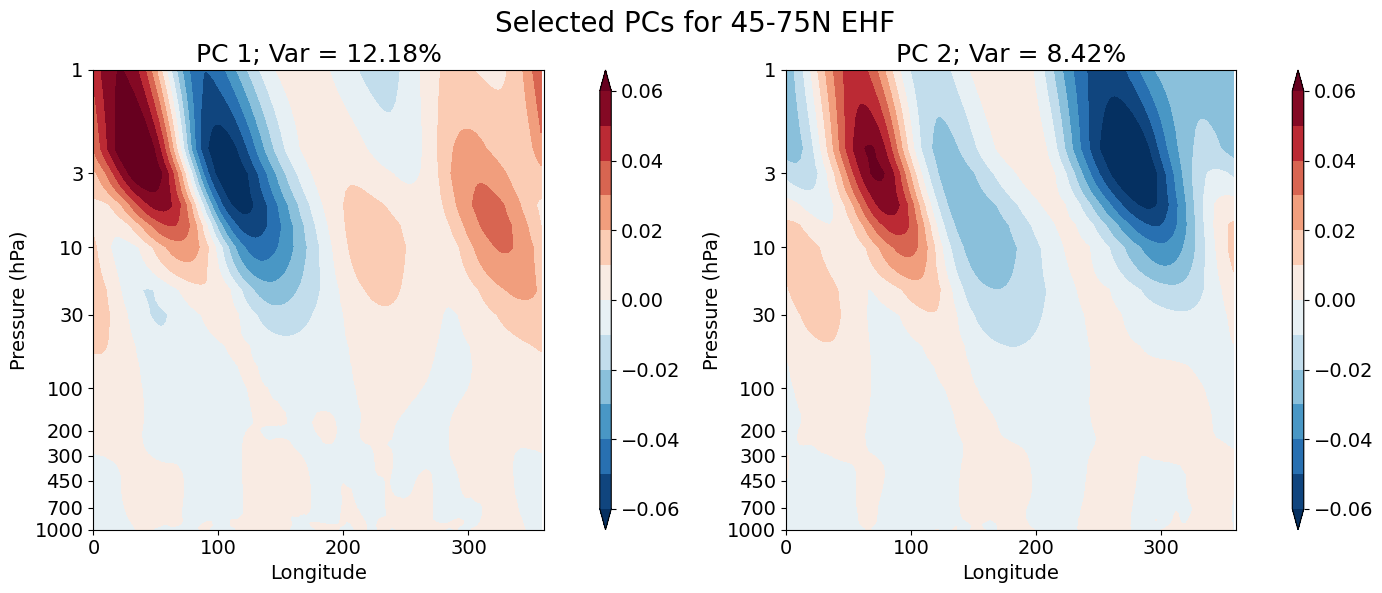

In [30]:
fs = 16

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("Selected PCs for 45-75N EHF",fontsize=20)   

axes = axes.flatten()
#remove the last (empty) axis

for i in range(0, 2):
    color = "RdBu_r"
    # colorbar options:
    colorbarMin = -0.06
    colorbarMax = 0.06
    colorspace = 0.01

    PC_ind = EHF_index[i] 

    clevel = np.arange(colorbarMin, colorbarMax + colorspace, colorspace)
    axes[i].set_title(
        str(EHF_plot[i]) + "; Var = " + str(round(EHF_VarEx[PC_ind], 2)) + "%", fontsize=18
    )
    h = axes[i].contourf(
        lon,
        lev,
        EHF_EOF_nw[PC_ind, :, :],
        clevel,
        cmap=color,
        extend="both",
    )
    cbar = plt.colorbar(
        h, orientation="vertical", shrink=1, fraction=0.1, pad=0.1, aspect=40
    )
    cbar.ax.tick_params(labelsize=fs-2)
    # colorLabel='Z (m)'
    # cbar.set_label(label=colorLabel,fontsize=10)
    
    axes[i].tick_params(labelsize=fs-2)
    axes[i].invert_yaxis()
    axes[i].set_yscale('symlog')
    axes[i].set_ylabel('Pressure (hPa)', fontsize=fs-2)
    axes[i].set_yticks([1, 3, 10, 30, 100, 200, 300, 450, 700, 1000]) 
    axes[i].get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

    axes[i].set_xlim(0, 360)
    axes[i].set_xlabel('Longitude', fontsize=fs-2)
       

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

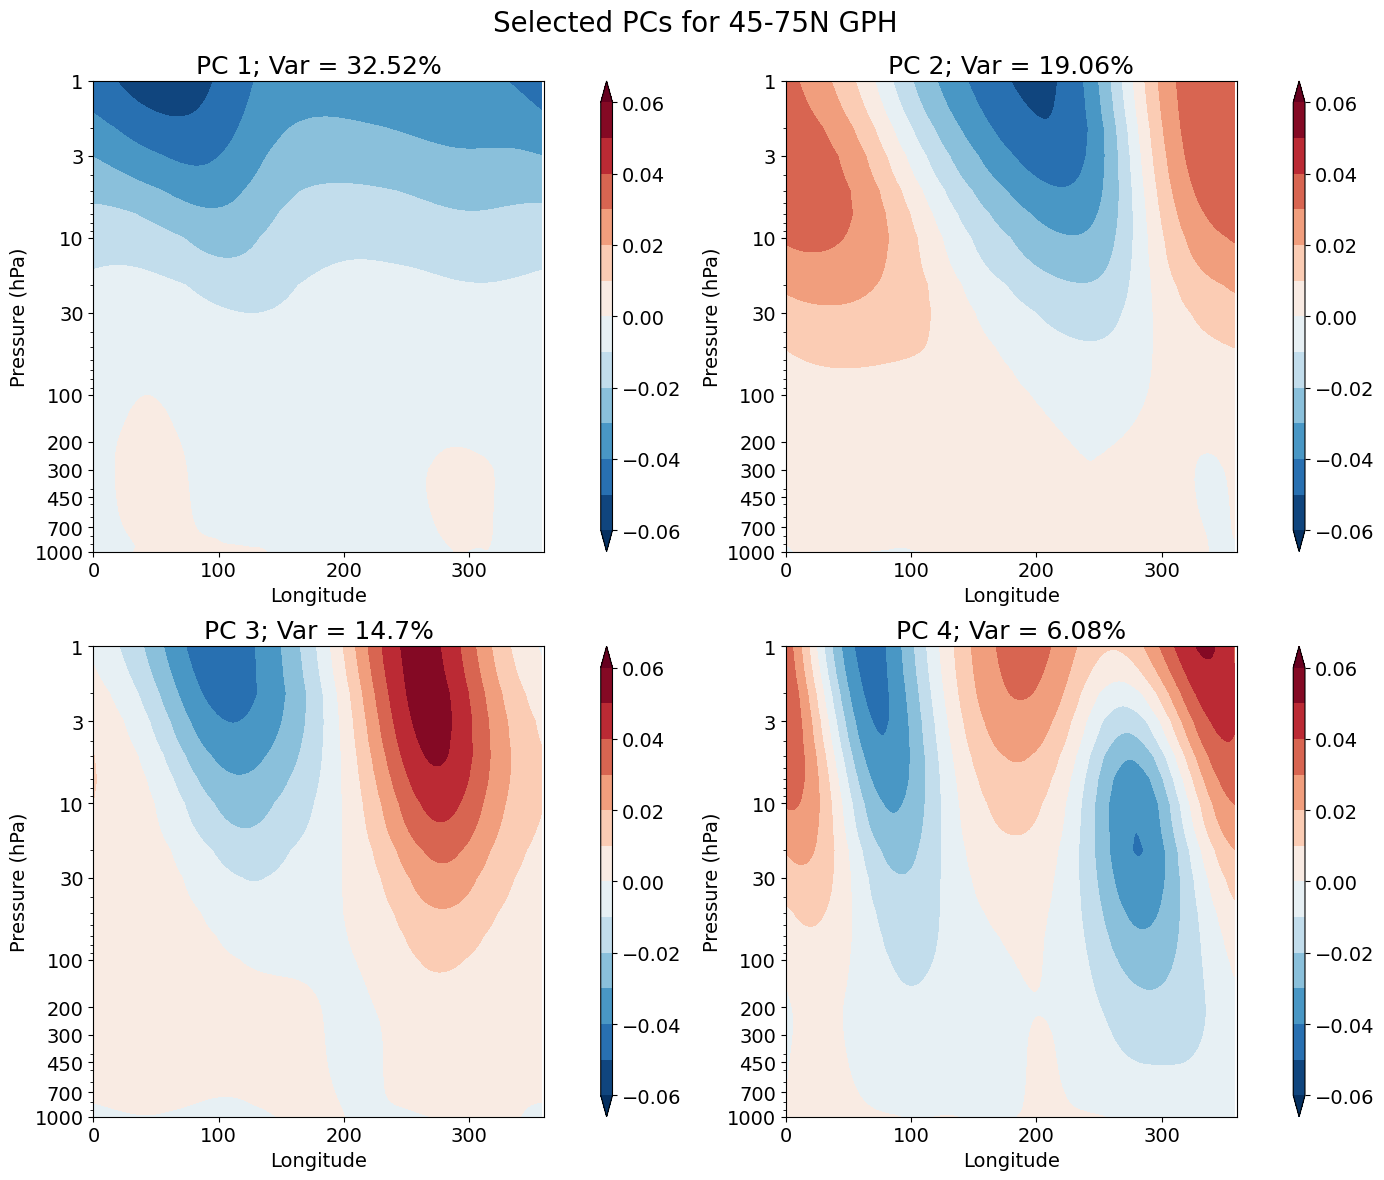

In [31]:
#constants
H = 7.5  #scale height in km
p0 = 1000  #reference pressure in hPa
#convert pressure levels to scale height (altitude in km)
height = -H * np.log(np.array(lev) / p0)

fs = 16

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.suptitle("Selected PCs for 45-75N GPH",fontsize=20)

axes = axes.flatten()
for i in range(0, 4):
    color = "RdBu_r"
    # colorbar options:
    colorbarMin = -0.06
    colorbarMax = 0.06
    colorspace = 0.01

    PC_ind = GPH_index[i]

    clevel = np.arange(colorbarMin, colorbarMax + colorspace, colorspace)
    axes[i].set_title(
        str(GPH_plot[i]) + "; Var = " + str(round(GPH_VarEx[PC_ind], 2)) + "%", fontsize=18
    )
    h = axes[i].contourf(
        lon,
        lev,
        GPH_EOF_nw[PC_ind, :, :],
        clevel,
        cmap=color,
        extend="both",
    )
    cbar = plt.colorbar(
        h, orientation="vertical", shrink=1, fraction=0.1, pad=0.1, aspect=40
    )
    cbar.ax.tick_params(labelsize=fs-2)
    # colorLabel='Z (m)'
    # cbar.set_label(label=colorLabel,fontsize=10)

    #axes[i].set_ylabel("Altitude (km)", fontsize=fs)
    #axes[i].set_yticks([0, 5, 10, 15, 20, 25, 30])
    #axes[i].set_ylim(height.max(), height.min())
    #axes[i].invert_yaxis()
    axes[i].tick_params(labelsize=fs-2)
    axes[i].set_yscale('log')
    axes[i].invert_yaxis()
    axes[i].set_ylabel('Pressure (hPa)', fontsize=fs-2)
    axes[i].set_yticks([1, 3, 10, 30, 100, 200, 300, 450, 700, 1000]) 
    axes[i].get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

    axes[i].set_xlim(0, 360)
    axes[i].set_xlabel('Longitude', fontsize=fs-2)
   
plt.tight_layout()
plt.subplots_adjust(top=0.92)